# Navigation Plus Logistic Regression Models Using Merged Data Experiment 1.1

In [1]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import csv
import pickle
import warnings
import stanza

from nltk import word_tokenize,pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

# Set random seed
random.seed(18)
seed = 18

# Ignore warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_colwidth', None)

# Initialize lemmatizer, stop words, and stanza
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline


2024-09-25 06:55:02 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-09-25 06:55:02 INFO: Downloading default packages for language: en (English) ...
2024-09-25 06:55:03 INFO: File exists: /Users/gbaldonado/stanza_resources/en/default.zip
2024-09-25 06:55:06 INFO: Finished downloading models and saved to /Users/gbaldonado/stanza_resources
2024-09-25 06:55:06 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-09-25 06:55:06 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-09-25 06:55:07 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-09-25 06:55:07 INFO: Using device: cpu
2024-09-25 06:55:07 INFO: Loading: tokenize
2024-09-25 06:55:07 INFO: Loading: mwt
2024-09-25 06:55:07 INFO: Loading: pos
2024-09-25 06:55:07 INFO: Loading: lemma
2024-09-25 06:55:07 INFO: Loading: constituency
2024-09-25 06:55:08 INFO: Loading: depparse
2024-09-25 06:55:08 INFO: Loading: sentiment
2024-09-25 06:55:08 INFO: Loading: 

## 1. Loading the data and quick exploratory data analysis

In [2]:
merged_navigational_df = pd.read_csv("../../../../data/processed_for_model/merged_themes_using_jaccard_method/merged_Navigational_sentence_level_batch_1_jaccard.csv", encoding='utf-8')

# Shuffle the merged dataset
merged_navigational_df = shuffle(merged_navigational_df, random_state=seed)

# Train-test split 
training_df, test_df = train_test_split(merged_navigational_df, test_size=0.2, random_state=18, stratify=merged_navigational_df['label'])

training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [3]:
training_df.head()

,sentence,label,phrase
0,i also have to take physics 2 next semester so i would like to have a firm understanding of the basic concepts before they get even more complicated.,0,"['I am in this class because I am not good at math. I know physics is very math heavy and conceptually confusing, so I knew sci would be perfect for me this semester. I also have to take physics 2 next semester so I would like to have a firm understanding of the basic concepts before they get even more complicated.']"
1,"after graduating high school there are three paths a person might take: work immediately, enroll into the military, or go back to school.",0,"[""I'm here at this institution becauase in order to do what I want to be when I grow up, I need a college degree. Planning to become a physical therapist requires a degree or some form of education. That is the main reason I'm here. After graduating high school there are three paths a person might take: work immediately, enroll into the military, or go back to school. So, I chose to go back to school.""]"
2,these are valuable skills that will definitely help me later on in life and going through a rigorous class will only help foster these skills even more.,0,['If I am going to be completely honest Im here to fulfill my requirements in order to graduate.']
3,"there are certain aspects of physics that i find to be very boring, for example: the math portion of it.",0,['it is a requirement for me to take Physics 111112 for my Biology Major']
4,"i want to represent myself, my gender, my sexuality, and my latina heritage and prove the world wrong that we do have the potential to flourish.",0,['Im currently lost as to how it is that I want to make my print in this world currently out of bio chemistry major not sure if I want to do research or medicine or neither Ill just go with the flow.']


In [4]:
test_df.head()

,sentence,label,phrase
0,why am i here?,0,"['Im here because I need to take this class as a prerequisite for the future courses I am obligated to take for my major.', 'So to encapsulate everything I have just stated I am taking this physics 2 course in order to fulfill existing prerequisites for future classes that I need to take for my major']"
1,"i choose this school because it was close and i enjoy living in sf, other places aren't as nice and i felt i would receive the most benefit going to a school in my city.",0,"['Currently I am taking this Astronomy 116 Lab for the lab credit to fulfill my general education requirements, I found my Astronomy 116 lecture to be more engaging then my Biology course.']"
2,i want to get a job in the film industry.,0,['I am here because I want to fulfill all of my GE requirements.']
3,these just are the reasons why im in here.,0,"['Beside getting the credit and meeting the GE requirement, I have the interest in it.']"
4,"i can't say i am the biggest fan of physics, but i do enjoy solving problems so i hope to be able to understand the work i do as well as be able to apply what i learn in other areas.",0,"['For this course, I expect to be able to relate the theory that I learn in 230 and be able to understand it in practical terms. I am a computer science major, so besides being required to take the course, I am looking to learn about the process that this course teaches you.']"


In [5]:
print(f"Training dataset shape: {training_df.shape} \nTest dataset shape: {test_df.shape}")
pos_labels = len([n for n in training_df['label'] if n==1])
print("Positive labels present in the dataset : {}  out of {} or {}%".format(pos_labels, len(training_df['label']), (pos_labels/len(training_df['label']))*100))
pos_labels = len([n for n in test_df['label'] if n==1])
print("Positive labels present in the test dataset : {}  out of {} or {}%".format(pos_labels, len(test_df['label']), (pos_labels/len(test_df['label']))*100))

Training dataset shape: (2556, 3) 
Test dataset shape: (640, 3)
Positive labels present in the dataset : 227  out of 2556 or 8.881064162754305%
Positive labels present in the test dataset : 57  out of 640 or 8.90625%


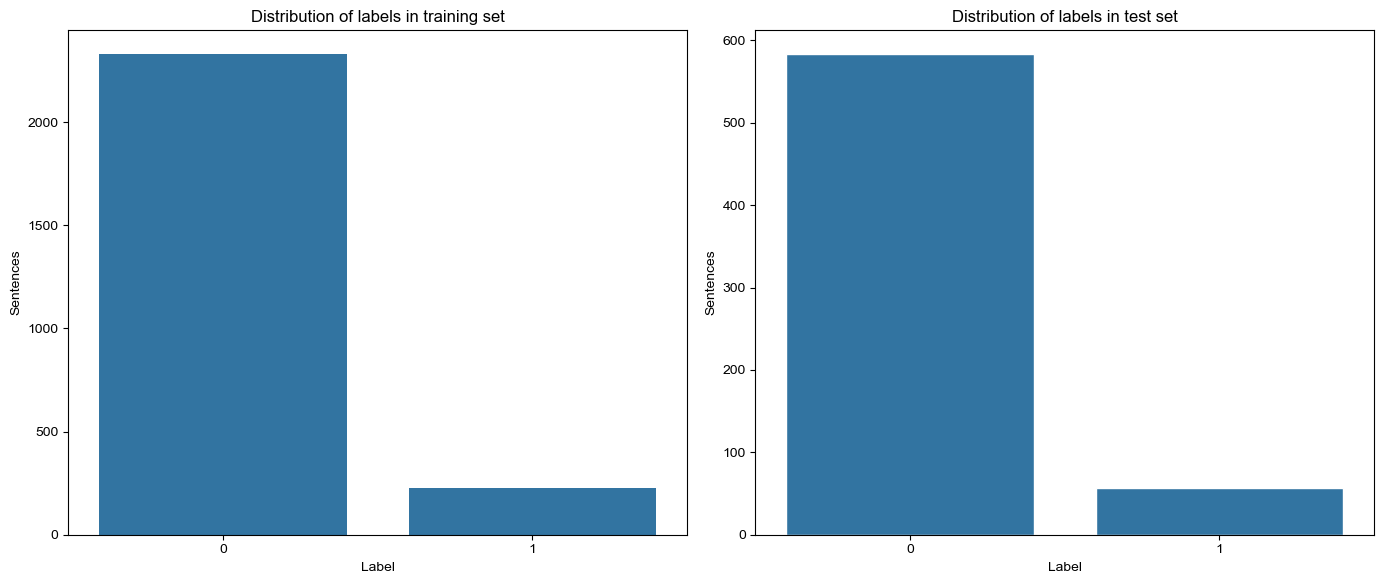

In [6]:
# Generate the data for the plots
training_counts = training_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the training set
sns.barplot(x=training_counts.index, y=training_counts.values, ax=axes[0])
axes[0].set_title('Distribution of labels in training set')
axes[0].set_ylabel('Sentences')
axes[0].set_xlabel('Label')
sns.set(style="whitegrid")

# Plot for the test set
sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1])
axes[1].set_title('Distribution of labels in test set')
axes[1].set_ylabel('Sentences')
axes[1].set_xlabel('Label')
sns.set(style="whitegrid")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## 2. Feature Engineering

### 1. NER

In [7]:
def get_ner(text):
    ner_list = []
    # Annotate the text using stanza
    doc = nlp(text)

    for sentence in doc.sentences:
        for entity in sentence.ents:
            if entity.type == 'PERSON':
                ner_list.append(entity.text)

    return ner_list

# Example usage
text = "Barack Obama was the 44th doctor of the United States."
print(get_ner(text))

['Barack Obama']


In [8]:
# check if a named entity is present in the sentence
def named_entity_present(sentence):
    ner_list = get_ner(sentence)
    if len(ner_list) > 0:
        return 1
    else:
        return 0

### 2. Similarity Features

In [9]:
# A helper function to get the similar words and similarity score
# The function takes tokens of sentence as input and if its not a stop word, get its similarity with synsets of STEM.
stop_words = set(stopwords.words('english'))
stop_words |= set(["help","try", "work", "process", "support", "job"] )
def word_similarity(tokens, syns, field):    
    if field in ['engineering', 'technology']:
        score_threshold = 0.5
    else:
        score_threshold = 0.2
    sim_words = 0
    for token in tokens:
        if token not in stop_words:
            try:
                syns_word = wordnet.synsets(token) 
                score = syns_word[0].path_similarity(syns[0])
                if score >= score_threshold:
                    sim_words += 1
            except: 
                score = 0
    
    return sim_words

In [10]:
# Functions to create columns for similarity based on all STEM fields
syns_bio = wordnet.synsets(lemmatizer.lemmatize("biology"))
syns_maths = wordnet.synsets(lemmatizer.lemmatize("mathematics")) 
syns_tech = wordnet.synsets(lemmatizer.lemmatize("technology"))
syns_eng = wordnet.synsets(lemmatizer.lemmatize("engineering"))
syns_chem = wordnet.synsets(lemmatizer.lemmatize("chemistry"))
syns_phy = wordnet.synsets(lemmatizer.lemmatize("physics"))
syns_sci = wordnet.synsets(lemmatizer.lemmatize("science"))

### 3. Medical Word Count

In [11]:
# Load the medical specialization text file and create a list
medical_list = []
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/medical_specialities.txt', 'r') as medical_fields:
    for line in medical_fields.readlines():
        special_field = line.rstrip('\n')
        special_field = re.sub("\W"," ", special_field )
#         print(special_field)
        medical_list += special_field.split()
medical_list = list(set(medical_list))  
medical_list = [x.lower() for x in medical_list]
print(medical_list)

['interventional', 'liaison', 'gastroenterology', 'immunology', 'cardiac', 'diagnostic', 'gastrointestinal', 'pediatrics', 'electrophysiology', 'neuroradiology', 'geriatric', 'oncology', 'infectious', 'medical', 'anesthesiology', 'rehabilitation', 'head', 'failure', 'behavioral', 'urology', 'transplant', 'dermatology', 'military', 'medicine', 'endocrinology', 'chemical', 'abuse', 'metabolism', 'interventional', 'orbit', 'ocular', 'adolescent', 'clinical', 'reproductive', 'sports', 'calculi', 'emergency', 'fetal', 'neonatal', 'perinatal', 'glaucoma', 'public', 'consultation', 'cardiothoracic', 'cytogenetics', 'reconstructive', 'hematology', 'maternal', 'reconstructive', 'cytopathology', 'critical', 'child', 'microbiology', 'neck', 'psychiatry', 'ophthalmology', 'forensic', 'molecular', 'cardiovascular', 'diabetes', 'pediatric', 'oncology', 'genetics', 'radiology', 'infectious', 'procedural', 'neuro', 'advanced', 'neuromuscular', 'uveitis', 'preventive', 'neurology', 'gynecologic', 'neur

In [12]:
# A helper function to get medical words
def check_medical_words(tokens):
    for token in tokens:
        if token not in stop_words and token in [x.lower() for x in medical_list]:
            return 1
        
    return 0

### 4. Sentiment Polarity and Subjectivity

In [13]:
# A helper function to get polarity and subjectivity of the sentence using TexBlob
def get_sentiment(sentence):
    sentiments =TextBlob(sentence).sentiment
    polarity = sentiments.polarity
    subjectivity = sentiments.subjectivity
    return polarity, subjectivity

### 5. POS Tag Count

In [14]:
# A helper function to get the count of POS tags of the sentence
def count_pos_tags(tokens):
    token_pos = pos_tag(tokens)
    count = Counter(tag for word,tag in token_pos)
    interjections =  count['UH']
    nouns = count['NN'] + count['NNS'] + count['NNP'] + count['NNPS']
    adverb = count['RB'] + count['RBS'] + count['RBR']
    verb = count['VB'] + count['VBD'] + count['VBG'] + count['VBN']
    determiner = count['DT']
    pronoun = count['PRP']
    adjetive = count['JJ'] + count['JJR'] + count['JJS']
    preposition = count['IN']
    return interjections, nouns, adverb, verb, determiner, pronoun, adjetive,preposition

In [15]:
def pos_tag_extraction(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

### 6. Word Embeddings

In [16]:
# Load the w2v dict from pickle file
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/pickle/embeddings06122024.pickle', 'rb') as w2v_file:
    w2v_dict = pickle.load(w2v_file)

In [17]:
print("length of word embeddings: ", len(w2v_dict.keys()))

length of word embeddings:  4762


In [18]:
# Get the vectors for the essay
def vectorizer(sequence):
    vect = []
    numw = 0
    for w in sequence: 
        try :
            if numw == 0:
                vect = w2v_dict[w]
            else:
                vect = np.add(vect, w2v_dict[w])
            numw += 1
        except Exception as e:
            pass

    return vect/ numw 

In [19]:
# Function to split text into words
def split_into_words(text):
    return text.split()

### 7. Unigrams

In [20]:
# Define the vectorizer
unigram_vect = CountVectorizer(ngram_range=(1, 1), min_df=2, stop_words = 'english')

### 8. Putting them all together

In [21]:
# Wrapper function for feature engineering
def feature_engineering(original_dataset):

    dataset = original_dataset.copy()
    # create a new column with sentence tokens
    dataset['tokens'] = dataset['sentence'].apply(word_tokenize)
    # 1. Similarity features
    # biology
    dataset['bio_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_bio,'biology',)) 
    # chemistry
    dataset['chem_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_chem,'chemistry',))
    # physics
    dataset['phy_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_phy,'physics',))
    # mathematics
    dataset['math_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_maths,'mathematics',))
    # technology
    dataset['tech_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_tech,'technology',))
    # engineering
    dataset['eng_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_eng,'engineering',))
    
    # medical terms
    dataset['medical_terms'] = dataset['tokens'].apply(check_medical_words)
    
    # polarity and subjectivity
    dataset['polarity'], dataset['subjectivity'] = zip(*dataset['sentence'].apply(get_sentiment))
    
    # named entity recognition
    dataset['ner'] = dataset['sentence'].apply(named_entity_present)
    
    # pos tag count
    dataset = pos_tag_extraction(dataset, 'tokens', count_pos_tags, ['interjections', 'nouns', 'adverb', 'verb', 'determiner', 'pronoun', 'adjetive','preposition'])
    
    # labels
    data_labels = dataset['label']
    # X
    data_x = dataset.drop(columns='label')

    
    # vectorize all the essays
    vect_arr = data_x.tokens.apply(vectorizer)
    for index in range(0, len(vect_arr)):
        i = 0
        for item in vect_arr[index]:
            column_name= "embedding" + str(i)
            data_x.loc[index, column_name] = item
            i +=1
    
    return data_x,data_labels
    

In [22]:
X_train, y_train = feature_engineering(training_df)

In [23]:
X_train.shape

(2556, 121)

In [24]:
y_train = y_train.astype('int')

In [25]:
X_test, y_test = feature_engineering(test_df)

In [26]:
X_test.shape

(640, 121)

In [27]:
y_test = y_test.astype('int')

**Calculate Unigram features for both train and test set**

In [28]:
X_train.shape

(2556, 121)

In [29]:
X_test.shape

(640, 121)

In [30]:
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Navigational/saved_features/X_test_final.csv", index=False)

In [31]:
X_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Navigational/saved_features/X_train_final.csv", index=False)
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Navigational/saved_features/X_test_final.csv", index=False)
y_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Navigational/saved_features/y_train.csv", index=False)
y_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Navigational/saved_features/y_test.csv", index=False)


In [32]:
# Unigrams for training set
unigram_matrix = unigram_vect.fit_transform(X_train['sentence'])
unigrams = pd.DataFrame(unigram_matrix.toarray())
print("Shape of the unigram df for train : ",unigrams.shape)
unigrams = unigrams.reset_index(drop=True)

Shape of the unigram df for train :  (2556, 1600)


In [33]:
X_train_final = pd.concat([X_train, unigrams], axis = 1)

In [34]:
X_train_final.columns = X_train_final.columns.astype(str)

In [35]:
X_train_final.shape

(2556, 1721)

In [36]:
unigram_matrix_test = unigram_vect.transform(X_test['sentence'])
unigrams_test = pd.DataFrame(unigram_matrix_test.toarray())
unigrams_test = unigrams_test.reset_index(drop=True)
print("Test unigram df shape : ",unigrams_test.shape)

Test unigram df shape :  (640, 1600)


In [37]:
X_test_final = pd.concat([X_test, unigrams_test], axis = 1)
X_test_final.shape

(640, 1721)

In [38]:
X_test_final.columns = X_test_final.columns.astype(str)

In [39]:
X_test_final.shape

(640, 1721)

In [40]:
for i in range(0, len(X_train_final.columns)):
    print('{} ---- {}'.format(i, X_train_final.columns[i]))

0 ---- sentence
1 ---- phrase
2 ---- tokens
3 ---- bio_sim_words
4 ---- chem_sim_words
5 ---- phy_sim_words
6 ---- math_sim_words
7 ---- tech_sim_words
8 ---- eng_sim_words
9 ---- medical_terms
10 ---- polarity
11 ---- subjectivity
12 ---- ner
13 ---- interjections
14 ---- nouns
15 ---- adverb
16 ---- verb
17 ---- determiner
18 ---- pronoun
19 ---- adjetive
20 ---- preposition
21 ---- embedding0
22 ---- embedding1
23 ---- embedding2
24 ---- embedding3
25 ---- embedding4
26 ---- embedding5
27 ---- embedding6
28 ---- embedding7
29 ---- embedding8
30 ---- embedding9
31 ---- embedding10
32 ---- embedding11
33 ---- embedding12
34 ---- embedding13
35 ---- embedding14
36 ---- embedding15
37 ---- embedding16
38 ---- embedding17
39 ---- embedding18
40 ---- embedding19
41 ---- embedding20
42 ---- embedding21
43 ---- embedding22
44 ---- embedding23
45 ---- embedding24
46 ---- embedding25
47 ---- embedding26
48 ---- embedding27
49 ---- embedding28
50 ---- embedding29
51 ---- embedding30
52 ---- em

### Model 1: Unigrams, POS Tag Count, Sentiment Polarity, Subjectivity

In [41]:
X_train_model_1 = X_train_final.iloc[:,np.r_[10:12,13:21,121:1721]]

In [42]:
X_train_model_1.shape

(2556, 1610)

In [43]:
X_test_model_1 = X_test_final.iloc[:,np.r_[10:12,13:21,121:1721]]

In [44]:
X_test_model_1.shape

(640, 1610)

In [45]:
model_1_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_1_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_1,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_1), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.447
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9631    0.8508    0.9035       583
           1     0.3040    0.6667    0.4176        57

    accuracy                         0.8344       640
   macro avg     0.6336    0.7587    0.6605       640
weighted avg     0.9044    0.8344    0.8602       640



In [46]:
lr_model_1 = LogisticRegression(random_state=18, 
                                solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], 
                                class_weight='balanced').fit(X_train_model_1, y_train)
y_lr = lr_model_1.predict(X_test_model_1)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 496, False Positive: 87, False Negative: 19, True Positive: 38
--------------------------------------------------------------------------------
[[496  87]
 [ 19  38]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       583
           1       0.30      0.67      0.42        57

    accuracy                           0.83       640
   macro avg       0.63      0.76      0.66       640
weighted avg       0.90      0.83      0.86       640



### Model 2: All Features

In [47]:
# X_train_model_2 = X_train_final.iloc[:,np.r_[3:1113]]
X_train_model_2 = X_train_final.iloc[:, np.r_[3:1721]]

In [48]:
X_train_model_2.shape

(2556, 1718)

In [49]:
X_test_model_2 = X_test_final.iloc[:,np.r_[3:1721]]

In [50]:
X_test_model_2.shape

(640, 1718)

In [51]:
model_2_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_2_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_2,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_2), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.449
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9630    0.8491    0.9025       583
           1     0.3016    0.6667    0.4153        57

    accuracy                         0.8328       640
   macro avg     0.6323    0.7579    0.6589       640
weighted avg     0.9041    0.8328    0.8591       640



In [52]:
lr_model_2 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_2, y_train)
y_lr = lr_model_2.predict(X_test_model_2)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 495, False Positive: 88, False Negative: 19, True Positive: 38
--------------------------------------------------------------------------------
[[495  88]
 [ 19  38]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       583
           1       0.30      0.67      0.42        57

    accuracy                           0.83       640
   macro avg       0.63      0.76      0.66       640
weighted avg       0.90      0.83      0.86       640



### Model 3: Without Unigrams

In [53]:
X_train_model_3 = X_train_final.iloc[:,np.r_[3:121]]

In [54]:
X_train_model_3.shape

(2556, 118)

In [55]:
X_test_model_3 = X_test_final.iloc[:,np.r_[3:121]]

In [56]:
X_test_model_3.shape

(640, 118)

In [57]:
model_3_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.0001, 0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_3_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_3,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_3), digits=4))

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best score: 0.379
Best parameters set:
	clf__C: 5
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9806    0.7787    0.8681       583
           1     0.2712    0.8421    0.4103        57

    accuracy                         0.7844       640
   macro avg     0.6259    0.8104    0.6392       640
weighted avg     0.9174    0.7844    0.8273       640



In [58]:
lr_model_3 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_3, y_train)
y_lr = lr_model_3.predict(X_test_model_3)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 454, False Positive: 129, False Negative: 9, True Positive: 48
--------------------------------------------------------------------------------
[[454 129]
 [  9  48]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       583
           1       0.27      0.84      0.41        57

    accuracy                           0.78       640
   macro avg       0.63      0.81      0.64       640
weighted avg       0.92      0.78      0.83       640



### Model 4: Without Embeddings

In [59]:
X_train_model_4 = X_train_final.iloc[:,np.r_[3:21,121:1721]]

In [60]:
X_train_model_4.shape

(2556, 1618)

In [61]:
X_test_model_4 = X_test_final.iloc[:,np.r_[3:21,121:1721]]

In [62]:
X_test_model_4.shape

(640, 1618)

In [63]:
model_4_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_4_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_4,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_4), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.445
Best parameters set:
	clf__C: 1
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9540    0.8902    0.9210       583
           1     0.3333    0.5614    0.4183        57

    accuracy                         0.8609       640
   macro avg     0.6437    0.7258    0.6697       640
weighted avg     0.8988    0.8609    0.8763       640



In [64]:
lr_model_4 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_4, y_train)
y_lr = lr_model_4.predict(X_test_model_4)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 519, False Positive: 64, False Negative: 25, True Positive: 32
--------------------------------------------------------------------------------
[[519  64]
 [ 25  32]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       583
           1       0.33      0.56      0.42        57

    accuracy                           0.86       640
   macro avg       0.64      0.73      0.67       640
weighted avg       0.90      0.86      0.88       640



### Model 5: Without POS Tag Count

In [65]:
X_train_model_5 = X_train_final.iloc[:,np.r_[3:13,21:1721]]

In [66]:
X_train_model_5.shape

(2556, 1710)

In [67]:
X_test_model_5 = X_test_final.iloc[:,np.r_[3:13,21:1721]]

In [68]:
X_test_model_5.shape

(640, 1710)

In [69]:
model_5_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_5_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_5,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_5), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.454
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       583
           1       0.31      0.67      0.42        57

    accuracy                           0.84       640
   macro avg       0.64      0.76      0.67       640
weighted avg       0.91      0.84      0.86       640



In [70]:
lr_model_5 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_5, y_train)
y_lr = lr_model_5.predict(X_test_model_5)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 499, False Positive: 84, False Negative: 19, True Positive: 38
--------------------------------------------------------------------------------
[[499  84]
 [ 19  38]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       583
           1       0.31      0.67      0.42        57

    accuracy                           0.84       640
   macro avg       0.64      0.76      0.67       640
weighted avg       0.91      0.84      0.86       640



### Model 6: Without STEM Similarity

In [71]:
X_train_model_6 = X_train_final.iloc[:,np.r_[10:1721]]

In [72]:
X_train_model_6.shape

(2556, 1711)

In [73]:
X_test_model_6 = X_test_final.iloc[:,np.r_[10:1721]]

In [74]:
X_test_model_6.shape

(640, 1711)

In [75]:
model_6_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_6_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_6,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_6), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.447
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       583
           1       0.30      0.65      0.41        57

    accuracy                           0.83       640
   macro avg       0.63      0.75      0.66       640
weighted avg       0.90      0.83      0.86       640



In [76]:
lr_model_6 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_6, y_train)
y_lr = lr_model_6.predict(X_test_model_6)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 497, False Positive: 86, False Negative: 20, True Positive: 37
--------------------------------------------------------------------------------
[[497  86]
 [ 20  37]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       583
           1       0.30      0.65      0.41        57

    accuracy                           0.83       640
   macro avg       0.63      0.75      0.66       640
weighted avg       0.90      0.83      0.86       640



### Model 7: Without Sentiment Features

In [77]:
X_train_model_7 = X_train_final.iloc[:,np.r_[3:10,12:1721]]

In [78]:
X_train_model_7.shape

(2556, 1716)

In [79]:
X_test_model_7 = X_test_final.iloc[:,np.r_[3:10,12:1721]]

In [80]:
X_test_model_7.shape

(640, 1716)

In [81]:
model_7_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_7_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_7,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_7), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.450
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       583
           1       0.31      0.68      0.42        57

    accuracy                           0.83       640
   macro avg       0.64      0.77      0.66       640
weighted avg       0.91      0.83      0.86       640



In [82]:
lr_model_7 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_7, y_train)
y_lr = lr_model_7.predict(X_test_model_7)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 495, False Positive: 88, False Negative: 18, True Positive: 39
--------------------------------------------------------------------------------
[[495  88]
 [ 18  39]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       583
           1       0.31      0.68      0.42        57

    accuracy                           0.83       640
   macro avg       0.64      0.77      0.66       640
weighted avg       0.91      0.83      0.86       640



### Model 8: Without NER

In [83]:
X_train_model_8 = X_train_final.iloc[:,np.r_[3:12,13:1721]]

In [84]:
X_train_model_8.shape

(2556, 1717)

In [85]:
X_test_model_8 = X_test_final.iloc[:,np.r_[3:12,13:1721]]

In [86]:
X_test_model_8.shape

(640, 1717)

In [87]:
model_8_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_8_pipeline, parameters, scoring="f1", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_8,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_8), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best score: 0.449
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       583
           1       0.30      0.67      0.42        57

    accuracy                           0.83       640
   macro avg       0.63      0.76      0.66       640
weighted avg       0.90      0.83      0.86       640



In [88]:
lr_model_8 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_8, y_train)
y_lr = lr_model_8.predict(X_test_model_8)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

Logistic regression Classifier
True Negative: 495, False Positive: 88, False Negative: 19, True Positive: 38
--------------------------------------------------------------------------------
[[495  88]
 [ 19  38]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       583
           1       0.30      0.67      0.42        57

    accuracy                           0.83       640
   macro avg       0.63      0.76      0.66       640
weighted avg       0.90      0.83      0.86       640



### Final Summary
| Experiment | Model Number | Features Used                                                | Precision | Recall | Macro F1 |
| :--------: | :----------: | :----------------------------------------------------------: | :-------: | :----: | :------: |
| Baseline   | 1            | Unigrams, POS Tag Count, Sentiment Polarity and Subjectivity | 0.64      | 0.74   | 0.66     |
| Baseline   | 2            | All features (baseline)                                      | 0.64      | 0.76   | 0.66     |
| Baseline   | 3            | Without Unigrams                                             | 0.61      | 0.72   | 0.59     |
| Baseline   | 4            | Without Embeddings                                           | 0.64      | 0.74   | 0.66     |
| Baseline   | 5            | Without POS tag                                              | 0.64      | 0.75   | 0.66     |
| Baseline   | 6            | Without STEM similarity (paper baseline)                     | 0.65      | 0.77   | 0.67     |
| Baseline   | 7            | Without sentiment features                                   | 0.64      | 0.75   | 0.66     |
| Baseline   | 8            | Without NER                                                  | 0.64      | 0.76   | 0.66     |